In [1]:
import os
import tarfile
from six.moves import urllib
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import hashlib
from sklearn.model_selection import train_test_split

DOWNLOAD_ROOT="https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH="datasets/housing"
HOUSING_URL=DOWNLOAD_ROOT+HOUSING_PATH+"/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path=os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz=tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()
    


def load_housing_data(housing_path=HOUSING_PATH):
    csv_path=os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)


def split_train_test(data, test_ratio):
    shuffled_indices=np.random.permutation(len(data))
    test_set_size=int(len(data)*test_ratio)
    test_indices=shuffled_indices[:test_set_size]
    train_indices=shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]


# fetch_housing_data()
housing=load_housing_data()

housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [2]:
# %matplotlib inline

# housing.head()
# housing.info()
# housing["ocean_proximity"].value_counts()
# housing.describe()

# housing.hist(bins=50, figsize=(20,15))
# plt.show()
# housing.hist(bins=30, figsize=(20,15))
# plt.show()
# housing.describe()
# housing.head()

# train_set, test_set=split_train_test(housing, 0.2)
# print(len(train_set), "train + ", len(test_set), "test")

def test_set_check(identifier, test_ratio, hash):
    return hash(np.int64(identifier)).digest()[-1] < 256*test_ratio

def split_train_test_by_id(data,test_ratio, id_column, hash=hashlib.md5):
    ids=data[id_column]
    in_test_set=ids.apply(lambda id_: test_set_check(id_, test_ratio, hash))
#     print (len(in_test_set))
#     trues=0
#     for id in in_test_set:
#         if id: 
#             trues+=1;
#     print(trues)
    
    return data.loc[~in_test_set], data.loc[in_test_set]

housing_with_id=housing.reset_index()
split_train_test_by_id(housing_with_id, 0.2, "index")
train_set, test_set=split_train_test_by_id(housing_with_id, 0.2, "index")
# train_set, test_set=train_test_split(housing, test_size=0.2, random_state=42)
print(len(train_set), len(test_set))



16362 4278


median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

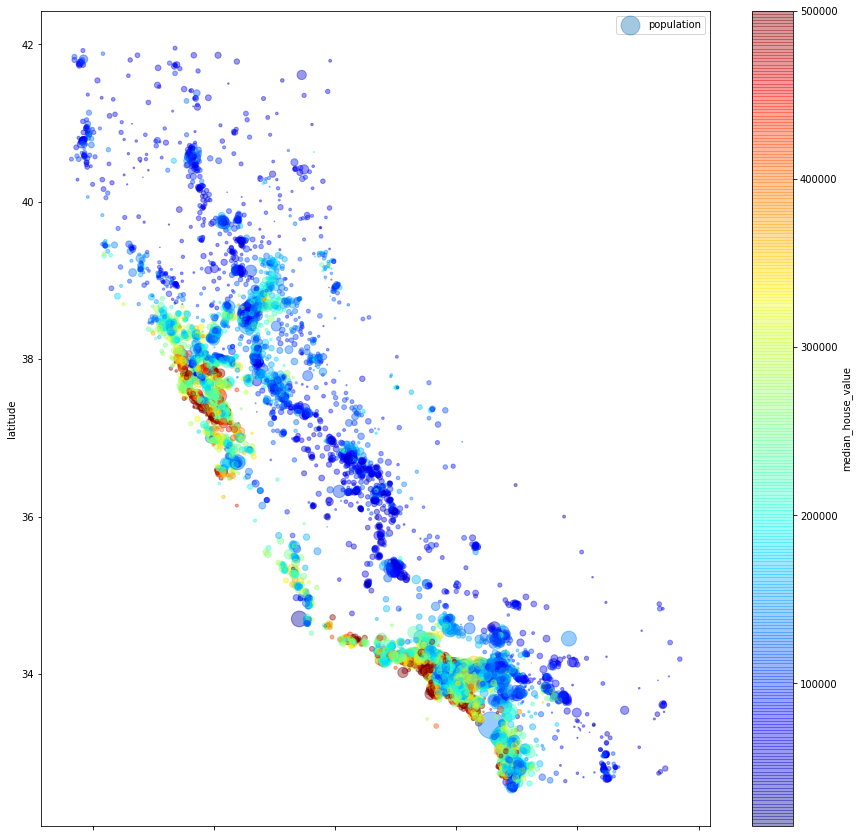

In [3]:
from  sklearn.model_selection import StratifiedShuffleSplit 
housing["income_cat"]=np.ceil(housing["median_income"]/1.5)
housing["income_cat"].where(housing["income_cat"]<5, 5.0, inplace=True)
# print(housing["income_cat"].value_counts()/len(housing))
# housing["income_cat"].hist()
split=StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
#     print(train_index, test_index)
    strat_train_set=housing.loc[train_index]
    strat_test_set=housing.loc[test_index]
# print(strat_train_set, strat_test_set)    
# print(strat_train_set["income_cat"].value_counts()/len(strat_train_set))
# print(strat_test_set["income_cat"].value_counts()/len(strat_test_set))
strat_train_set.drop(["income_cat"],axis=1, inplace=True)
housing_train=strat_train_set.copy()
# housing_train.plot(kind="scatter", x="longitude", y="latitude", alpha=0.2)
housing_train.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4, s=housing_train["population"]/50, label="population",
                  c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,figsize=(15,15))
plt.legend()
corr_matrix=housing_train.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

In [14]:
from pandas.plotting import scatter_matrix
attributes=["median_house_value", "median_income", "total_rooms", "housing_median_age"]
# scatter_matrix(housing_train[attributes], figsize=(12,8))

# housing_train.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.1)
housing_train["rooms_per_household"]=housing_train["total_rooms"]/housing_train["households"]
housing_train["bedrooms_per_room"]=housing_train["total_bedrooms"]/housing_train["total_rooms"]
housing_train["population_per_household"]=housing_train["population"]/housing_train["households"]

corr_matrix=housing_train.corr()

print(corr_matrix["median_house_value"].sort_values(ascending=False))
housing=housing_train.drop("median_house_value", axis=1)
housing_labels=housing_train["median_house_value"].copy()

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64


In [48]:
#Data Cleaning
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import LabelBinarizer

np.set_printoptions(suppress=True)
imputer=SimpleImputer(missing_values=np.nan, strategy="median")
# housing["ocean_proximity"].value_counts()
housing_num=housing.drop("ocean_proximity", axis=1)
imputer.fit(housing_num)
# print(housing_num.head(5),'\n', imputer.statistics_)
X=imputer.transform(housing_num)
housing_tr=pd.DataFrame(X, columns=housing_num.columns)
# print(housing_tr)
encoder=LabelEncoder()
housing_cat=housing["ocean_proximity"]
housing_encoded=encoder.fit_transform(housing_cat)
# print(housing_encoded, encoder.classes_)
# print(housing["ocean_proximity"])
encoder=OneHotEncoder()
housing_cat_1hot=encoder.fit_transform(housing_encoded.reshape(-1,1))
# print(housing_cat_1hot.toarray())

encoder=LabelBinarizer()
housing_cat_1hot=encoder.fit_transform(housing_cat)
print(housing_cat_1hot)

[[1 0 0 0 0]
 [1 0 0 0 0]
 [0 0 0 0 1]
 ...
 [0 1 0 0 0]
 [1 0 0 0 0]
 [0 0 0 1 0]]


/home/hd/.local/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
